In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
__author__ = 'Author'
__email__ = 'Email'

# Taxonomy of Problems in Sentential Semantics
## Contradiction to Word Prediction

In [ ]:
# dependency
# built-in
import os, json, gzip
# third-party
import torch
import pandas as pd
from tqdm import tqdm
from src.llama3 import Llama as Llama3
from src.llama3.tokenizer import Tokenizer as Llama3Tokenizer
# local
from config import Config
from src.neg import Negator
from src.wp import Con2WP

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Initialization

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
config = Config()
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for k,v in config.__dict__.items():
    print(f'{k}: {v}')

seed: 0
spacy_model: en_core_web_sm
max_seq_len: 512
max_batch_size: 1
temperature: 0.0
top_p: 1.0
max_gen_len: 1
task: con2wp
data: samples17.tsv
lm: Meta-Llama-3-8B-Instruct
CURR_PATH: ./
RESOURCE_PATH: ./res
LLMS_PATH: ./res/llms
DATA_PATH: ./res/data
TASK_DATA_PATH: ./res/data/con2wp
RESULTS_PATH: ./res/results
TASK_RESULTS_PATH: ./res/results/con2wp/Meta-Llama-3-8B-Instruct
FIGURES_PATH: ./res/results/figures
TASK_FIGURES_PATH: ./res/results/figures/con2wp/Meta-Llama-3-8B-Instruct
DATA_JSON: ./res/data/con2wp/samples17.tsv.json.gz
RESULTS_TSV: ./res/results/con2wp/Meta-Llama-3-8B-Instruct/samples17.tsv.tsv
RESULTS_JSON: ./res/results/con2wp/Meta-Llama-3-8B-Instruct/samples17.tsv.json.gz
LM_PATH: ./res/llms/Meta-Llama-3-8B-Instruct
TOKENIZER_PATH: ./res/llms/Meta-Llama-3-8B-Instruct/tokenizer.model
PARAMS_JSON: ./res/llms/Meta-Llama-3-8B-Instruct/params.json
LOG_PATH: ./res/log/con2wp/Meta-Llama-3-8B-Instruct/samples17.tsv.log
device: cpu


## Model

In [4]:
tokenizer = Llama3Tokenizer(model_path=config.TOKENIZER_PATH)

In [5]:
llama = Llama3.build(
    ckpt_dir=config.LM_PATH,
    tokenizer_path=config.TOKENIZER_PATH,
    max_seq_len=config.max_seq_len,
    max_batch_size=config.max_batch_size,
)
llama.model.eval()

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 4.56 seconds


Transformer(
  (tok_embeddings): VocabParallelEmbedding()
  (layers): ModuleList(
    (0-31): 32 x TransformerBlock(
      (attention): Attention(
        (wq): ColumnParallelLinear()
        (wk): ColumnParallelLinear()
        (wv): ColumnParallelLinear()
        (wo): RowParallelLinear()
      )
      (feed_forward): FeedForward(
        (w1): ColumnParallelLinear()
        (w2): RowParallelLinear()
        (w3): ColumnParallelLinear()
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): ColumnParallelLinear()
)

In [6]:
# Negator
negator = Negator(config)

In [7]:
# con2wp = LlamaCon2WP(llama, negator, config)
con2wp = Con2WP(llama.model, llama.tokenizer, negator, config)

In [ ]:
p = 'Since John is in the garage, therefore'
h = 'Sophia is in the office.'
h_ = 'Sophia is in the basement.'

# p = 'Sophia is in the kitchen.'
# h = 'Sophia is in the bathroom.'
# h_ = 'Sophia is in the kitchen.'

p = con2wp.encode(p)
h, h_ = con2wp.encode(h, h_, bos=False)

In [39]:
p

[128000, 12834, 71471, 374, 304, 279, 19833, 11, 9093]

In [47]:
i = 5
# premise with the hypothesis1
ph0 = torch.LongTensor(p + [con2wp.space_id] + h[:i]).reshape(1, -1)
# premise with the hypothesis2
ph1  = torch.LongTensor(p + [con2wp.space_id] + h_[:i]).reshape(1, -1)
ph0 == ph1

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True]])

In [48]:
ph0

tensor([[128000,  12834,  71471,    374,    304,    279,  19833,     11,   9093,
            220,  86332,    689,    374,    304,    279]])

In [49]:
ph0.shape

torch.Size([1, 15])

In [50]:
# TODO: the bos should be removed after P + H
llama.tokenizer.decode(ph0[0].tolist()), llama.tokenizer.decode(ph1[0].tolist())

('<|begin_of_text|>Since Sophia is in the garage, therefore Sophia is in the',
 '<|begin_of_text|>Since Sophia is in the garage, therefore Sophia is in the')

In [51]:
top1, vocab_ps = con2wp.wp(ph0)

In [52]:
top1, llama.tokenizer.decode([top1])

(19833, ' garage')

In [53]:
# ! need to start with a space
# tk = ' bedroom'
# tk_id = llama.tokenizer.encode(tk, bos=False, eos=False)
# tk, llama.tokenizer.decode(tk_id), tk_id

In [54]:
# llama.tokenizer.decode([2788, 3039])

In [55]:
# p.shape, p[14150].item()

In [56]:
# return top 10 with prob from the resulting vocab prob distribution
ps, idxes = torch.topk(vocab_ps, 20)
for i, p in zip(idxes, ps):
    print(llama.tokenizer.decode([i.item()]), round(p.item(), 4))

 garage 0.871
 house 0.0125
  0.0036
.
 0.0027
gar 0.0025
 room 0.0023

 0.002
 box 0.0019
 car 0.0017
. 0.0017
, 0.0015
 garden 0.0014
 building 0.0013
 ( 0.0013
 is 0.0012
 kitchen 0.0012
 Garage 0.0011
 same 0.001
 .
 0.001
 basement 0.0009


In [23]:
vocab_ps

tensor([7.0963e-05, 5.5501e-05, 8.4505e-06,  ..., 1.7929e-10, 1.7934e-10,
        1.7930e-10])

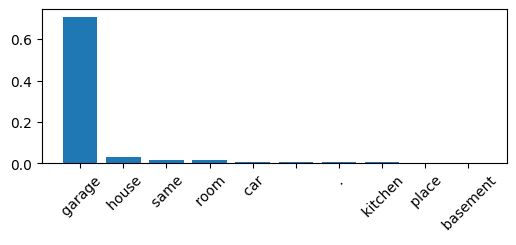

In [24]:
# show ws and prob in bar chart
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 2))
plt.bar([llama.tokenizer.decode([i.item()]) for i in idxes], ps)
plt.xticks(rotation=45)
plt.show()


## Scale UP

In [21]:
# Read the TSV file into a DataFrame
file = 'samples17.tsv'
SAMPLE_TSV = os.path.join(config.DATA_PATH, config.task, file)
samples_df = pd.read_csv(SAMPLE_TSV, sep='\t')
ps = samples_df['premise'].tolist()
hs = samples_df['hypothesis'].tolist()
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     20 non-null     object
 1   hypothesis  20 non-null     object
dtypes: object(2)
memory usage: 452.0+ bytes


In [22]:
samples_df.head()

,premise,hypothesis
0,Sophia is in the kitchen.,Sophia is in the bathroom.
1,John is in the bathroom.,John is in the bedroom.
2,Michael is in the office.,Michael is in the bedroom.
3,David is in the bedroom.,David is in the office.
4,Michael is in the office.,Michael is in the kitchen.


In [23]:
phs = []
for p, h in zip(samples_df['premise'], samples_df['hypothesis']):
    pronoun = None
    for name in ['Mary', 'Emily', 'Alice', 'Sophia']:
        if name in p:
            pronoun = 'she'
            break
    for name in ['John', 'James', 'Michael', 'David']:
        if name in p:
            pronoun = 'he'
            break
    ph = 'Since ' + p[:-1] + ', therefore ' + pronoun + ' ' + ' '.join(h.split()[1:-1])
    phs.append(ph)

In [25]:
probs_dict = {}
for i, ph in enumerate(tqdm(phs)):
    en_ph = torch.LongTensor(con2wp.encode(ph)).reshape(1, -1)
    top1, vocab_ps = con2wp.wp(en_ph)
    ps, idxes = torch.topk(vocab_ps, 15)
    probs_dict[i] = {}
    probs_dict[i]['ph'] = ph
    probs_dict[i]['top1'] = llama.tokenizer.decode([top1])
    probs_dict[i]['top15_probs'] = [round(prob.item(), 4) for prob in ps]
    # probs_dict[i]['top15_id'] = [idx.item() for idx in idxes]
    probs_dict[i]['top15_tokens'] = ', '.join([llama.tokenizer.decode([idx.item()]) for idx in idxes])
    # break

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


In [30]:
# convert the dict to a DataFrame
probs_df = pd.DataFrame(probs_dict).T
probs_df.head()

,ph,top1,top15_probs,top15_tokens
0,"Since Sophia is in the kitchen, therefore she ...",kitchen,"[0.8749, 0.0099, 0.0096, 0.0094, 0.0062, 0.005...","kitchen, room, house, act, same, state, ..."
1,"Since John is in the bathroom, therefore he is...",bathroom,"[0.4339, 0.101, 0.0457, 0.0277, 0.0265, 0.0261...","bathroom, house, room, toilet, same, bui..."
2,"Since Michael is in the office, therefore he i...",office,"[0.6608, 0.0282, 0.0188, 0.0166, 0.0145, 0.010...","office, building, same, room, house, pre..."
3,"Since David is in the bedroom, therefore he is...",bedroom,"[0.3264, 0.1865, 0.1696, 0.0479, 0.024, 0.0163...","bedroom, house, room, bed, same, state, ..."
4,"Since Michael is in the office, therefore he i...",office,"[0.6608, 0.0282, 0.0188, 0.0166, 0.0145, 0.010...","office, building, same, room, house, pre..."


In [31]:
# add premise and hypothesis to the DataFrame
probs_df['premise'] = samples_df['premise']
probs_df['hypothesis'] = samples_df['hypothesis']
probs_df.head()

,ph,top1,top15_probs,top15_tokens,premise,hypothesis
0,"Since Sophia is in the kitchen, therefore she ...",kitchen,"[0.8749, 0.0099, 0.0096, 0.0094, 0.0062, 0.005...","kitchen, room, house, act, same, state, ...",Sophia is in the kitchen.,Sophia is in the bathroom.
1,"Since John is in the bathroom, therefore he is...",bathroom,"[0.4339, 0.101, 0.0457, 0.0277, 0.0265, 0.0261...","bathroom, house, room, toilet, same, bui...",John is in the bathroom.,John is in the bedroom.
2,"Since Michael is in the office, therefore he i...",office,"[0.6608, 0.0282, 0.0188, 0.0166, 0.0145, 0.010...","office, building, same, room, house, pre...",Michael is in the office.,Michael is in the bedroom.
3,"Since David is in the bedroom, therefore he is...",bedroom,"[0.3264, 0.1865, 0.1696, 0.0479, 0.024, 0.0163...","bedroom, house, room, bed, same, state, ...",David is in the bedroom.,David is in the office.
4,"Since Michael is in the office, therefore he i...",office,"[0.6608, 0.0282, 0.0188, 0.0166, 0.0145, 0.010...","office, building, same, room, house, pre...",Michael is in the office.,Michael is in the kitchen.


In [32]:
# change the order of the columns
probs_df = probs_df[['premise', 'hypothesis', 'ph', 'top1', 'top15_tokens', 'top15_probs']]
probs_df.head()

,premise,hypothesis,ph,top1,top15_tokens,top15_probs
0,Sophia is in the kitchen.,Sophia is in the bathroom.,"Since Sophia is in the kitchen, therefore she ...",kitchen,"kitchen, room, house, act, same, state, ...","[0.8749, 0.0099, 0.0096, 0.0094, 0.0062, 0.005..."
1,John is in the bathroom.,John is in the bedroom.,"Since John is in the bathroom, therefore he is...",bathroom,"bathroom, house, room, toilet, same, bui...","[0.4339, 0.101, 0.0457, 0.0277, 0.0265, 0.0261..."
2,Michael is in the office.,Michael is in the bedroom.,"Since Michael is in the office, therefore he i...",office,"office, building, same, room, house, pre...","[0.6608, 0.0282, 0.0188, 0.0166, 0.0145, 0.010..."
3,David is in the bedroom.,David is in the office.,"Since David is in the bedroom, therefore he is...",bedroom,"bedroom, house, room, bed, same, state, ...","[0.3264, 0.1865, 0.1696, 0.0479, 0.024, 0.0163..."
4,Michael is in the office.,Michael is in the kitchen.,"Since Michael is in the office, therefore he i...",office,"office, building, same, room, house, pre...","[0.6608, 0.0282, 0.0188, 0.0166, 0.0145, 0.010..."


In [33]:
# save the DataFrame to a TSV file
probs_df.to_csv('res/results/samples17_wp.tsv', sep='\t', index=False)

## Llama CON

In [237]:
# load json.gz file
file = 'ent_babi'
json_path = f'res/results/{file}.json.gz'
# Open and load the JSON.gz file
with gzip.open(json_path, 'rt', encoding='utf-8') as f:
    data = json.load(f)
type(data), len(data)


(dict, 50)

In [238]:
data.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49'])

In [239]:
data['0']

{'premise': 'Sophia travelled to the hallway.',
 'hypothesis': 'Sophia journeyed to the hallway.',
 'llama': 'False'}

In [240]:
data

{'0': {'premise': 'Sophia travelled to the hallway.',
  'hypothesis': 'Sophia journeyed to the hallway.',
  'llama': 'False'},
 '1': {'premise': 'Mary journeyed to the bedroom.',
  'hypothesis': 'Mary travelled to the bedroom.',
  'llama': 'False'},
 '2': {'premise': 'Emily journeyed to the garden.',
  'hypothesis': 'Emily travelled to the garden.',
  'llama': 'False'},
 '3': {'premise': 'John went to the bedroom.',
  'hypothesis': 'John journeyed to the bedroom.',
  'llama': 'False'},
 '4': {'premise': 'Daniel moved to the cellar.',
  'hypothesis': 'Daniel moved to the cellar.',
  'llama': 'False'},
 '5': {'premise': 'Alice went to the study.',
  'hypothesis': 'Alice went to the study.',
  'llama': 'False'},
 '6': {'premise': 'Emily moved to the loft.',
  'hypothesis': 'Emily travelled to the loft.',
  'llama': 'True'},
 '7': {'premise': 'James travelled to the pub.',
  'hypothesis': 'James travelled to the pub.',
  'llama': 'False'},
 '8': {'premise': 'John went to the study.',
  'hy

In [241]:
preds = []
for v in data.values():
    pred = v['llama']
    preds.append(pred)
len(preds)

50

In [242]:
len([_ for _ in preds if _ == 'True']), len([_ for _ in preds if _ == 'False'])

(4, 46)

In [219]:
# convert the results and save as tsv
results = []
for k, v in data.items():
    results.append({'premise': v['premise'], 'hypothesis': v['hypothesis'], 'llama': v['llama']})
results_df = pd.DataFrame(results)
# reanme the columns as Premise, Hypothesis, and Prediction
results_df.columns = ['Premise', 'Hypothesis', 'Prediction']
results_df.head()

,Premise,Hypothesis,Prediction
0,Daniel is in the hallway.,Daniel is in the bedroom.,True
1,Mary is in the bedroom.,Mary is in the office.,True
2,John is in the bedroom.,John is in the garden.,False
3,Daniel is in the bedroom.,Daniel is in the hallway.,False
4,Sandra is in the office.,Sandra is in the garden.,False


In [220]:
# save as tsv
results_df.to_csv(f'res/results/{file}.tsv', sep='\t', index=False)